# Artificial *Bokeh* using Stereo Vision

## Load Images and Ground Truths

I have linked some images from the Middlebury 2003 dataset. Go to http://vision.middlebury.edu/stereo/data/ to view more images. It should be rectified image as this code does not do any rectification.

In [1]:
## Get images from the internet using wget
!wget http://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im2.png -O left_img.png
!wget http://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im6.png -O right_img.png

--2019-03-29 12:03:05--  http://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im2.png
Resolving webproxy (webproxy)... 10.36.26.1
Connecting to webproxy (webproxy)|10.36.26.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 362946 (354K) [image/png]
Saving to: ‘left_img.png’

left_img.png        100%[===================>] 354.44K  1.11MB/s    in 0.3s    

2019-03-29 12:03:06 (1.11 MB/s) - ‘left_img.png’ saved [362946/362946]

--2019-03-29 12:03:06--  http://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im6.png
Resolving webproxy (webproxy)... 10.36.26.1
Connecting to webproxy (webproxy)|10.36.26.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 364420 (356K) [image/png]
Saving to: ‘right_img.png’

right_img.png       100%[===================>] 355.88K  1.17MB/s    in 0.3s    

2019-03-29 12:03:07 (1.17 MB/s) - ‘right_img.png’ saved [364420/364420]



In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import sys

## Define names of images
left_img_name = "left_img.png"
right_img_name = "right_img.png"

## Read images
left_img = cv.imread(left_img_name)
right_img = cv.imread(right_img_name)

plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1, title='Left Image')
plt.imshow(cv.cvtColor(left_img, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2, title='Right Image')
plt.imshow(cv.cvtColor(right_img, cv.COLOR_BGR2RGB))

plt.show()

# Convert to Grayscale for disparity calculations
left_img_gray = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
right_img_gray = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Mask Creation Function

Create another image where pixels with disparity value between x and y would be 0 (Black) else it would be 255 (White). This will then serve as a guide for the smoothing filter. Only 'White' pixels would be smoothed.

In [3]:
def createMask(dmap, fRange):    
    x, y = fRange
    
    if x >= 255:
        print('X value must be less than 255, It should be at most the maximum value in the Disparity Range.')
        return
    
    temp = np.copy(dmap)
    temp[(temp < x) | (temp > y)] = 255
    temp[(temp >= x) & (temp <= y)] = 0
    
    return temp

## Stereo Block Matching (Plane Sweeping)

This is a simple method where a window of a certain size is drawn over 1 image and that will be the template. The tempate is then searched for in the 2nd image.

Since, we are working with rectified images, we can leverage the epipolar lines to lower the computation cost of searching for the template. Instead of searching in 2-Dimensions, we will only be searching in 1-Dimension.

### Sum of Squared Differences

The use of Euclidean Distance to measure the dissimilarity between the windows/template.

In [4]:
def stereoBM_ssd(im_l, im_r, b_size, disparityRange):
    """ Find disparity image using Sum of Squared Differences. """
    
    print('Starting Block Matching SSD')
    
    m, n = im_r.shape

    # Array to hold depth planes
    dmaps = np.zeros((m, n))
    
    # Block matching with nested for-loops
    for r in range(m):
        minr = max(0, r-b_size)
        maxr = min(m-1, r+b_size)
        for c in range(n):
            minc = max(0, c-b_size)
            maxc = min(n-1, c+b_size)
            
            # Calculate Disparity Range
            mind = disparityRange[0]
            maxd = min(disparityRange[1], n-maxc)
            
            # Construct template from the right image
            template = im_r[minr:maxr, minc:maxc]

            # Search template in the left image - Calculate SSD
            numBlocks = maxd - mind
            scores = cv.matchTemplate(im_l[minr:maxr, minc+mind:minc+maxd], template, method=cv.TM_SQDIFF_NORMED)
            
            # Find the index of the best matched region
            # It is the disparity
            matched_idx = np.argmin(scores)
            dmaps[r, c] = matched_idx + mind
        
        sys.stdout.write('Row %d/%d \r' % (r+1, m))
        sys.stdout.flush()
        
    return dmaps

### Normalised Cross Correlation

The use Normalised Cross Correlation to measure the dissimilarity between template/window.

In [5]:
def stereoBM_ncc(im_l, im_r, b_size, disparityRange):
    """ Find disparity image using Normalised Cross Correlation. """
    
    print('Starting Block Matching NCC')
    
    m, n = im_r.shape

    # Array to hold depth planes
    dmaps = np.zeros((m, n))
    
    # Block matching with nested for-loops
    for r in range(m):
        minr = max(0, r-b_size)
        maxr = min(m-1, r+b_size)
        for c in range(n):
            minc = max(0, c-b_size)
            maxc = min(n-1, c+b_size)
            
            # Calculate Disparity Range
            mind = disparityRange[0]
            maxd = min(disparityRange[1], n-maxc)
            
            # Construct template from the right image
            template = im_r[minr:maxr, minc:maxc]

            # Search template in the left image - Calculate NCC
            numBlocks = maxd - mind
            scores = cv.matchTemplate(im_l[minr:maxr, minc+mind:minc+maxd], template, method=cv.TM_CCORR_NORMED)
                
            # Find the index of the best matched region
            # It is the disparity
            matched_idx = np.argmax(scores)
            dmaps[r, c] = matched_idx + mind
        
        sys.stdout.write('Row %d/%d \r' % (r+1, m))
        sys.stdout.flush()
        
    return dmaps

## Demonstration of Block Matching (Plane Sweeping)

Run the code on the test images provided. Perform masking and use ipython widgets to provide sliders for interactive changes of the selected depth. User will be able to view the 'bokeh' effect being applied to the regions outside the selected depth range.

In [6]:
dmap_ssd = stereoBM_ssd(left_img_gray, right_img_gray, 4, [0, 64])

Starting Block Matching SSD


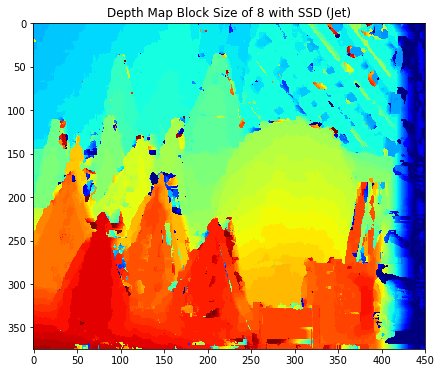

In [7]:
plt.figure(figsize = (8, 6))
plt.title('Depth Map Block Size of 8 with SSD (Jet)')
plt.imshow(dmap_ssd, cmap='jet')
plt.show()

In [8]:
def masking(x, y):
    dmap_ssd_mask = createMask(dmap_ssd, (x, y))
    
    smooth_img = np.copy(right_img)
    temp = smooth_img[dmap_ssd_mask == 0]
    smooth_img = cv.GaussianBlur(smooth_img, (7, 7), 3)
    smooth_img[dmap_ssd_mask == 0] = temp
    
    plt.figure(figsize = (16, 12))
    plt.subplot(1, 2, 1, title='Mask')
    plt.imshow(dmap_ssd_mask, cmap='gray')
    plt.subplot(1, 2, 2, title='Blurred Image')
    plt.imshow(smooth_img)
    plt.show()
    
ipywidgets.interact_manual(masking, x=(0, np.max(dmap_ssd), 1), y=(0, np.max(dmap_ssd), 1))

interactive(children=(FloatSlider(value=28.0, description='x', max=56.0, step=1.0), FloatSlider(value=28.0, de…

<function __main__.masking>

In [9]:
dmap_ncc = stereoBM_ncc(left_img_gray, right_img_gray, 4, [0, 64])

Starting Block Matching NCC


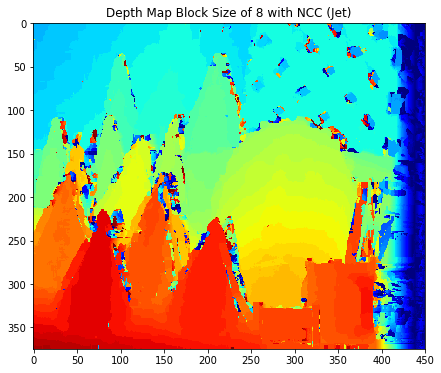

In [10]:
plt.figure(figsize = (8, 6))
plt.title('Depth Map Block Size of 8 with NCC (Jet)')
plt.imshow(dmap_ncc, cmap='jet')
plt.show()

In [11]:
def masking(x, y):
    dmap_ncc_mask = createMask(dmap_ncc, (x, y))
    
    smooth_img = np.copy(right_img)
    temp = smooth_img[dmap_ncc_mask == 0]
    smooth_img = cv.GaussianBlur(smooth_img, (7, 7), 3)
    smooth_img[dmap_ncc_mask == 0] = temp
    
    plt.figure(figsize = (16, 12))
    plt.subplot(1, 2, 1, title='Mask')
    plt.imshow(dmap_ncc_mask, cmap='gray')
    plt.subplot(1, 2, 2, title='Blurred Image')
    plt.imshow(smooth_img)
    plt.show()
    
ipywidgets.interact_manual(masking, x=(0, np.max(dmap_ncc), 1), y=(0, np.max(dmap_ncc), 1))

interactive(children=(FloatSlider(value=28.0, description='x', max=56.0, step=1.0), FloatSlider(value=28.0, de…

<function __main__.masking>

## Dynamic Programming (Unconstrained)

In [12]:
def stereoDP(im_l, im_r):
    """ Find disparity image using Dynamic Programming. """
    
    print('Starting Dynamic Programming')
    
    m, n = im_r.shape
    dmap_l = np.zeros((m, n))
    dmap_r = np.zeros((m, n))
    
    occlusionCost = 20
    
    # Build Disparity Space Image
    for r in range(m):
        
        dsi = np.zeros((n, n))
        dpath = np.zeros((n, n))
        
        for i in range(0, n):
            dsi[i][0] = i*occlusionCost
            dsi[0][i] = i*occlusionCost
        
        for c in range(n):
            left = im_l[r, c]
            for d in range(0, n):
                right = im_r[r, d]
                cost = np.abs(int(left)-int(right))
                
                # Find path
                min1 = dsi[c-1, d-1]+cost
                min2 = dsi[c-1][d]+occlusionCost
                min3 = dsi[c][d-1]+occlusionCost
                cmin = np.min((min1, min2, min3))
                dsi[c, d] = cmin
                
                if min1 == cmin:
                    dpath[c, d] = 1
                elif min2 == cmin:
                    dpath[c, d] = 2
                elif min3 == cmin:
                    dpath[c, d] = 3
        
        # Explore Path and Set disparity value
        i = n-1
        j = n-1
        while i!=0 and j!=0:
            if dpath[i, j] == 1:
                dmap_l[r, i] = np.abs(i-j)
                dmap_r[r, j] = np.abs(i-j)                
                i = i-1
                j = j-1
            elif dpath[i, j] == 2:
                i = i-1
            elif dpath[i, j] == 3:
                j = j-1
            else:
                print('i =', i, ', j =', j)
                return dsi, dpath
        
        sys.stdout.write('Row %d/%d \r' % (r+1, m))
        sys.stdout.flush()
        
    return dmap_l, dmap_r

## Dynamic Programming Demonstration

In [13]:
dmap_dp = stereoDP(left_img_gray, right_img_gray)

Starting Dynamic Programming


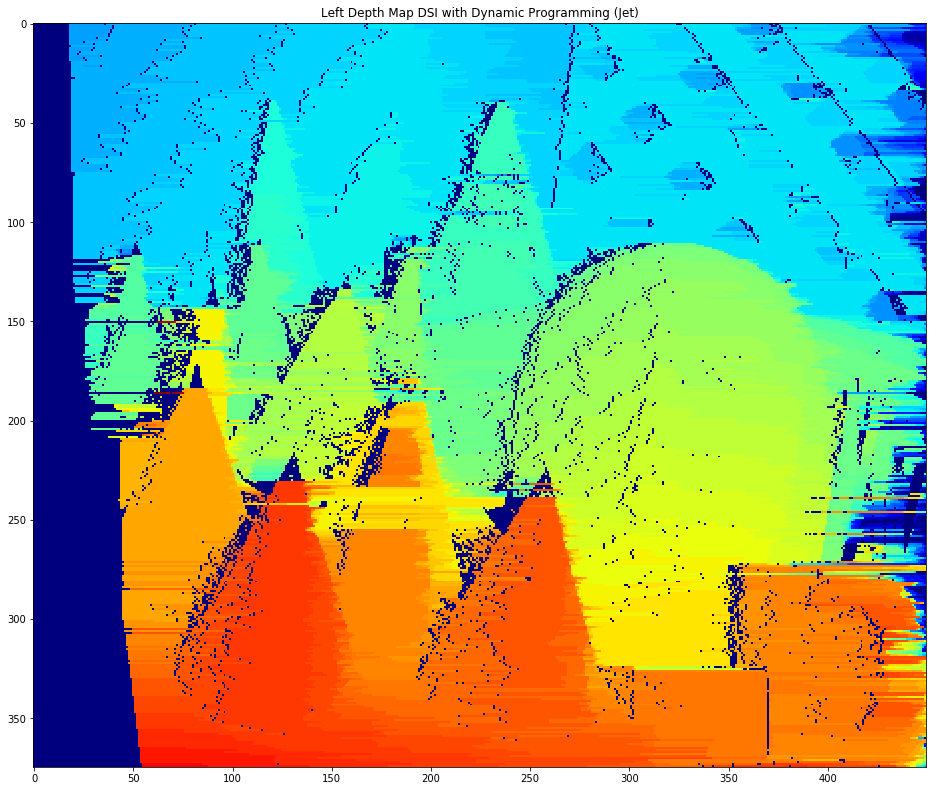

In [14]:
plt.figure(figsize = (16, 16))
plt.title('Left Depth Map DSI with Dynamic Programming (Jet)')
plt.imshow(dmap_dp[0], cmap='jet')
plt.show()

In [15]:
def masking(x, y):
    dmap_dp_mask = createMask(dmap_dp[0], (x, y))
    
    smooth_img = np.copy(left_img)
    temp = smooth_img[dmap_dp_mask == 0]
    smooth_img = cv.GaussianBlur(smooth_img, (7, 7), 3)
    smooth_img[dmap_dp_mask == 0] = temp
    
    plt.figure(figsize = (20, 20))
    plt.subplot(1, 2, 1, title='Mask')
    plt.imshow(dmap_dp_mask, cmap='gray')
    plt.subplot(1, 2, 2, title='Blurred Image')
    plt.imshow(smooth_img)
    plt.show()
    
ipywidgets.interact(masking, x=(0, np.max(dmap_dp[0]), 1), y=(0, np.max(dmap_dp[0]), 1))

interactive(children=(FloatSlider(value=30.0, description='x', max=60.0, step=1.0), FloatSlider(value=30.0, de…

<function __main__.masking>

NameError: name 'right_ground_truth' is not defined

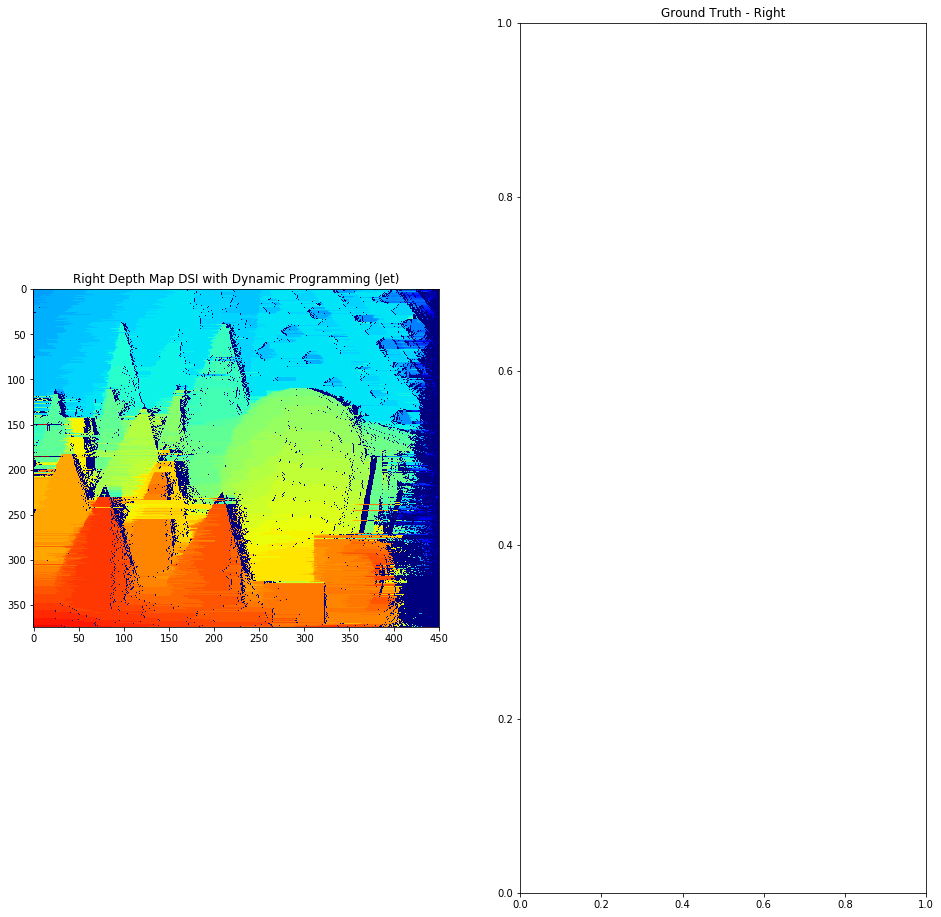

In [16]:
plt.figure(figsize = (16, 16))
plt.subplot(1, 2, 1, title='Right Depth Map DSI with Dynamic Programming (Jet)')
plt.imshow(dmap_dp[1], cmap='jet')
plt.subplot(1, 2, 2, title='Ground Truth - Right')
plt.imshow(right_ground_truth)
plt.show()

In [ ]:
def masking(x, y):
    dmap_dp_mask = createMask(dmap_dp[1], (x, y))
    
    smooth_img = np.copy(right_img)
    temp = smooth_img[dmap_dp_mask == 0]
    smooth_img = cv.GaussianBlur(smooth_img, (7, 7), 3)
    smooth_img[dmap_dp_mask == 0] = temp
    
    plt.figure(figsize = (20, 20))
    plt.subplot(1, 2, 1, title='Mask')
    plt.imshow(dmap_dp_mask, cmap='gray')
    plt.subplot(1, 2, 2, title='Blurred Image')
    plt.imshow(smooth_img)
    plt.show()
    
ipywidgets.interact(masking, x=(0, np.max(dmap_dp[1]), 1), y=(0, np.max(dmap_dp[1]), 1))